In [4]:
#import mpld3 
#mpld3.enable_notebook() 
from scipy.io.wavfile import read
from scipy import signal
import matplotlib.pyplot as plt
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
#plt.rcParams['figure.figsize'] = (9,4)
from IPython.display import Math, Image

### Short time Fourier transform

Recall that a DFT takes in a time-domain signal and outputs the frequency-domain content of that signal *over the entire time period of the input.*

In [5]:
Image(url="https://audiotech2images.s3.us-east-2.amazonaws.com/dft_recipe.png")

The DFT tells us about the frequency content for some signal, s. The built-in assumption, however, is that the signal's frequency content is *unchanging over time*.

Of course, for most "real" signals there are typically many frequency components that change over the course of the signal. Throughout the signal, then, we will need to know not only what the frequency components are, but also know *when* each frequency occurs. Remember: the spectrum does not contain any information about time!

The short-time fourier transform (or STFT for short) is a way of using the Fourier transform to analyze signal content that evolves over time. It works by taking very short slices of the time-based input signal and performing the DFT on each slice. With a short enough time slice, it is assumed that the frequency component(s) of that short segment is stationary, and so we can compute the DFT on that slice.

Let's look at a simple example.

We have a signal that changes in frequency content over time, with clear stop and start positions for each tone:

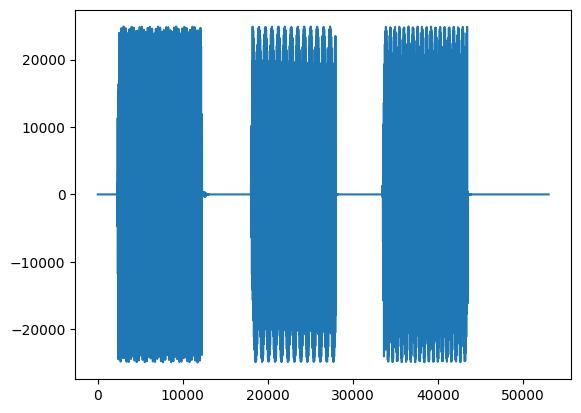

In [6]:
fs,data = read('../audio/dialTones.wav')
plt.plot(data)

In [7]:
from IPython.display import Audio
Audio(data, rate=44100)

If we run a DFT on this complete signal, we get the following:

(0.0, 5000.0)

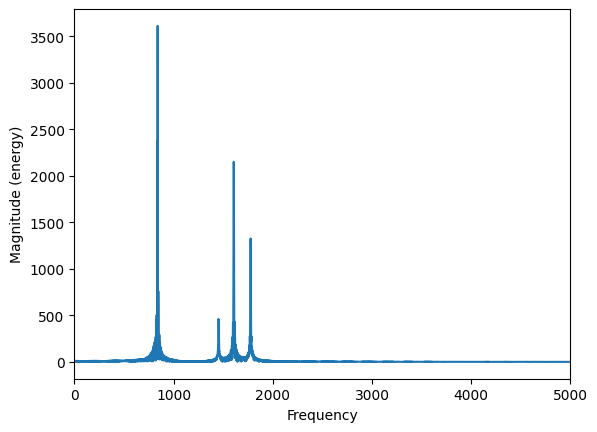

In [8]:
import numpy as np
import matplotlib.pyplot as plt

plt.magnitude_spectrum(data,data.size); 
plt.xlim(0,5000) # zoomed to show relevant output

So we can see that altogether there are many different frequency components, but we don't know when they occurred. In other words, the time domain doesn't tell us about what frequencies are present, and the frequency spectrum doesn't tell us anything about *when* they happen.

So, in order to estimate *both* the 'what' and the 'when', we take the audio signal, split it into small segments ("frames"), and apply a Fourier transform to each (a technique known as the **short time Fourier transform** or STFT). The length of this frame (snippet of time) is typically in the range of 10 to 50ms).

For reasons yet to be explained, we must apply an envelope function (i.e., "window function") to each frame of our analysis...

Thus the output $X[m,k]$ is the Fourier transform of the (typically **windowed**) input at each discrete time $n$ for each discrete frequency bin $k$. [More on frequency bins in a minute]. 

Since we are effectively computing a series of DFTs, the STFT is, (like the DFT), a complex-valued function that outputs a **sequence of spetra**. In other words, instead of having a vector sequnce of coefficients (what we get from the DFT), we get a *matrix* of coefficients, where the column index represents time, and the row index is associated with the frequency of the respective DFT coefficient.

The STFT is commonly represented as below (or some similar representation), which you should recognize as a modification of the DFT equation:


$$X[m,k] = \sum_{n=0}^{N-1} x(n + mH)w(n)\cdot e^{-j2*\pi kn/N}$$

In the above equation "m" is the frame number or frame index, and H is the "hop size" or shift lag in number of samples. $x[n]$ is now the portion of the original signal that sits inside our analysis window. $X[m,k]$ is a complex value denoting the $k$th Fourier coefficient at the $m$th time frame.

We can most easily visualize this by first applying a rectangular window across our signal:

In [9]:
Image(url="https://audiotech2images.s3.us-east-2.amazonaws.com/hopping1.png", width=600)

In the above example, we have a frame size of 200 (samples), and a hop size of 100 samples (i.e., 50%). A rectangular window is applied such that everything inside the window in this case is simply multiplied by 1.

So we compute a DFT over N number of samples. 

Let's go back and compute the DFT for a few windows of our original example signal. (Note this is not an implementation of the full STFT because we have not windowed the entire signal but it's a good demo.)

1) N = 256 (sample 2560 to 2816) --burst one (M = 10)  
2) N = 256 (sample 18,176 to 18,432) -- burst two, (M=71)     
3) N = 256 (sample 37,120 to 37,376) -- burst three, (M=145)  

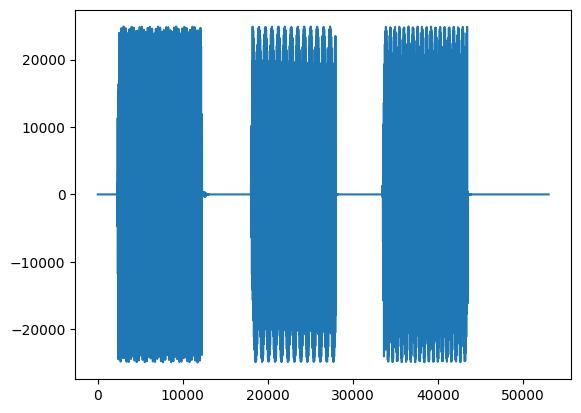

In [10]:
#recall our original signal here
fs,data = read('../audio/dialTones.wav')
plt.plot(data)

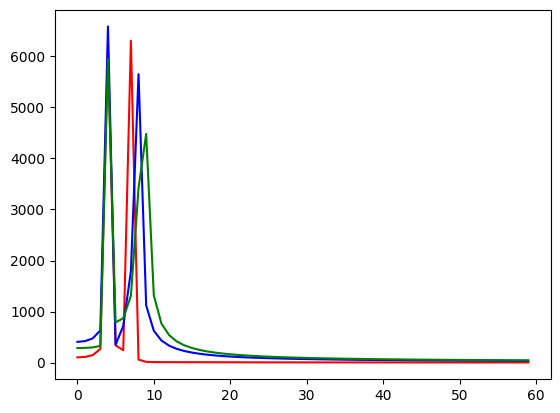

In [11]:
f1 = data[2560:2816]
f2 = data[18176:18432]
f3 = data[37120:37376]
N = f1.size
#For now, I'm using an efficient implementation of the DFT in numpy for real-valued signals
mx1 = np.fft.rfft(f1/N) 
mx2 = np.fft.rfft(f2/N)
mx3 = np.fft.rfft(f3/N)
plt.plot(abs(mx1)[:60],'r',abs(mx2)[:60],'b', abs(mx3)[:60],'g')

Above, each 'run' of the DFT is color-coded. The first one is red, the second blue, and the third green. You can guess that they each have the same lower harmonic component because the spikes overlap (we only see the last color -- green), but the upper component is getting incrementally higher. 

Of course, here in the spectral domain those three time components are overlaid over each other because we have no way of representing time. In order to figure out *when* those time periods happened, we would need to know the number of samples passed at the beginning of our analysis frame, and the sample rate...

Recall from the DFT assignment that the number of $k$ (frequency) bins available to you was limited by the length of the input and the sampling rate. E.g., if your N was 64 then you could not find frequency components above k=64 (in fact, for a real-valued input signal, above k/2 or k=32). 

So we have been looking at segments where the assumption is that the full periodicity of the signal completes during the course of the window (so say, N=64 and k=7).  Thus our "sampling rate" divided by N was always equal to 1 so it was convenient to think of each "bin" as incrementing by k=1 (e.g., 1hz, 2hz, 3hz, etc.)

However, **the size (or resolution) of the $k$ bins is equal to the sampling rate divided by N**. Therefore if we take a smaller or larger number of samples in comparison to the size of the sampling rate (or, in this case, frame size), we change the resolution of the frequency bin such that it no longer increments by 1.

Let's keep this in mind as we continue...

## Spectrogram
The spectrogram is a useful tool for capturing and visualizing this time varying spectral information. Since we are looking at very small windows of time, and most often our signal will be varying more rapidly over time (compared with our example) the above method will not be useful. 

In order to represent this multidimensional data, we *color code the magnitude* of the fourier tranform, where large values are light or bright, and small values are dark.

We then lay these spectral "slices" one over top the other to form bands or rows of spectral data.  

One way of plotting the spectrogram is with matplotlib's function:

Text(0, 0.5, 'Frequency')

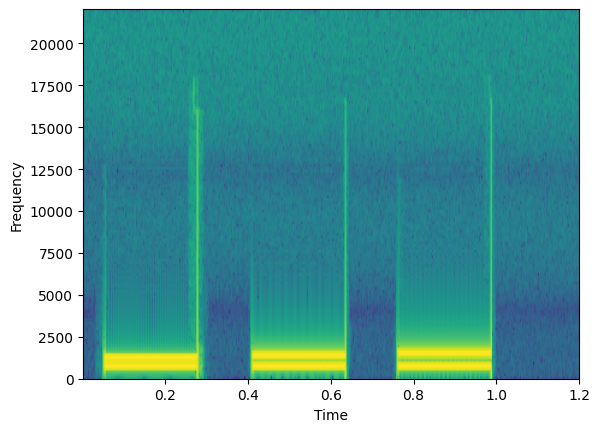

In [12]:
#matplotlib actually carries out the fourier transforms for you from your original signal
plt.specgram(data, NFFT=256, Fs=44100) 
plt.xlabel('Time')
plt.ylabel('Frequency')

Here is an example of our frequency content over time. We can see the bright yellow bands correspond to the frequency components of each sound burst. 

Notice our axis can be plotted with regard to the original time of the signal (because it's the same length). 

A question that might come to mind at this point is:  

**What about the length of the analysis window?**
Above I chose a window length of 256. Why? Is it the optimal size? What happens if we choose a larger window or a smaller window?  

Recall that when we compute **a DFT it is assuming a periodic signal**. So we are "chopping up" the signal in an STFT hoping to find small segments that don't vary much in frequency content. 

However, many times, the signal in a given window may have frequency components that **have not have traversed an integer number of periods**. Therefore, the
finite-ness of the measured signal may result in a truncated waveform with different
characteristics from the original continuous-time signal, and the artificial abrupt "cutting off" of the signal at the end of the window can introduce sharp
transition changes into the measured signal. 

This can create spurious high frequency content. It appears as if energy at one frequency leaks into other frequencies. This phenomenon is known as **spectral leakage**, which causes the fine spectral lines to spread into
wider signals.

You can minimize the effects of performing a DFT over a noninteger number of cycles by using
a technique called **windowing** (effectively, applying an envelope function to each window of time). Windowing reduces the amplitude of the discontinuities at the boundaries of each finite sequence.

This will minimize these high frequency artifacts. 

Some common windowing functions include: rectangular, hann, blackman, blackman-harris, hamming... we will return to these later.

The most important thing to understand about the STFT is the necessary **time-frequency resolution tradeoff** which is related to the **size** of the analysis window.

### Time-Frequency tiling

STFT determines a tiling of the time-frequency plane, where the size of each tile is specified by the time and the frequency resolution of the STFT. 

So, as always, the highest positive frequency we can detect will be Fs/2 Hz, and the highest **frequency resolution** (how finely we can "resolve" any frequency components in the DFT) will be Fs/M Hz.

Suppose we choose a window size of length 256. What we have is a subdivision of the time axis into chunks that are 256 samples long, and subdivision of the frequency axis into bins where **the size of the bin in Hz is equal to the sampling rate divided by N** (or the maximum frequency divided by N/2) and the number of valid components (or frequency "bins") is equal to N/2 or 128. The size (or capacity) of the frequency axis "bins" determines our maximum frequency resolution. In the above example case, 44100/256=172Hz. **So each bin is approximately 172Hz wide.** There are 128 of these bins which brings us to 128 x 172.265 = 22050 which is our Nyquist limit.

If we change the length of the time window, suppose we take M=128, then we narrow the size of tile along the time axis, but we would therefore widen the size of the tile along the frequency axis. So now our maximum frequency resolution would be 44100/128=~344.5Hz.

You can think of each tile below as returning a unique DFT value. 

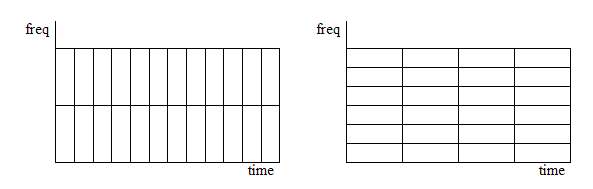

In [13]:
from IPython.display import Image

Image('../images/time_freq.png', embed=True, width=800)

So although the shape of the tiles change, the total number of tiles remains the same, because the area of each tile remains constant.

The STFT can therefore be viewed as the output of a series of filters, or a collection of spectral sequences, each corresponding to the frequency components of x[n] falling within a particular **frequency band**

So spectrograms can be either **wideband** or **narrowband** according to the frequency resolution of the associated DFT:

**Long window: narrowband spectrogram**    
    > If our L is big, we will have more DFT points = more frequency resolution.  
    > However, in a long window, more *things* can happen in the time domain = less precision in time  

**Short window: wideband spectrogram**  
    > short L means fewer DFT points = poor frequency resolution  
    > short L means we capture many slices of time = precise location of transitions  

If you don't have it already, pause and download the free software Audacity [here](https://www.audacityteam.org/download/)

Let's have a look at the difference between a wideband and narrowband spectrogram using *Audacity*. If you are unsure how to get to spectrogram view in Audacity, kindly watch the short video I posted to Canvas.

Looking at files:
  * FemaleSingingScale.wav
  * chirp-150-190-linear.wav
  * ThreeTwoOne.wav
  
Listen to each of the files. The first is a simple scale with lots of space between notes, the second is a sweep with no space between tones (making it basically impossible to isolate a frequency because it is constantly changing). The last is speech only. 

Look at the first two using spectrogram view. In spectrogram settings play between moving towards most narrowband (long time window) and towards most wideband (short time window). What would appear to be the best setting for each of those two files for obtaining the magnitude spectrum content?

The main disadvantage with the STFT is the **uncertainty** that it generates uncertainty in the frequency when the window period is too short, and, conversely, uncertainty in the time domain, when the window period is increased. This trade-off is very similar to the well-known "uncertainty principle" which is present in Quantum Mechanics.

### Speech analysis
A common use of spectrogram is in speech (and singing voice) analysis. Speech is a difficult signal to analyze. When you produce a vowel, you are producing a harmonic sound. Vowels have poor onset resolution. On the other hand, consonants have a noise-like structure, but tend to have good onset resolution. So in order to analyze a speech utterance, we need to split it into pieces and analyze them in small units.

Go back to Audacity and see if you can predict the 'noisy' consonant sounds from the harmonic vowel sounds using spectrogram in the last audio example above.

So narrowband spectrogram is useful for extracting harmonic (or vowel) sounds, hopefully you will see that while wideband spectrogram is useful for extracting information with fast-changing components such as noise-like (or consonant) sounds.